# Projet Télédétection Avancée UE:901_2  + Qualité et Fouille UE: 906

NOM: DASSI FENGAING 
Prénom: Alain Théophile

Données utilisées: pyrenees_24-25 et échantillons PI_strates_pyrenees_32630


# Introduction Générale

La classification d’images de télédétection constitue une étape clé pour transformer des données brutes en cartes thématiques exploitables. Elle permet d’identifier et de discriminer différents types de surfaces (sols nus, végétation, zones artificialisées, cultures, etc.) à partir de leurs signatures spectrales. Les méthodes de classification supervisée, et notamment celles basées sur l’apprentissage automatique, offrent aujourd’hui des performances élevées et une grande capacité de généralisation, à condition d’être correctement paramétrées et validées.

Ce projet s’inscrit dans cette dynamique et vise à mettre en œuvre une chaîne complète de traitement d’images allant du prétraitement des données jusqu’à la production d’une image classifiée finale constituée des classes comme du sol nu, herbe, landes et arbre. Il mobilise des outils de traitement numérique et des bibliothèques scientifiques afin de manipuler les données raster, entraîner un modèle de classification, évaluer l’importance des variables utilisées et générer une sortie cartographique cohérente et exploitable dans un SIG.

Une attention particulière est portée à la gestion des valeurs NoData, à la cohérence radiométrique et à la compatibilité des résultats avec les logiciels de cartographie tels que QGIS. L’objectif final est de produire une carte fiable et interprétable, tout en respectant les bonnes pratiques en télédétection et en traitement des données géospatiales.

Ce travail permet ainsi de consolider des compétences à la fois théoriques et pratiques en télédétection, en analyse spatiale et en programmation appliquée, tout en répondant à des enjeux concrets de production et de qualité de l’information géographique.

In [1]:
# Importation des librairies utiles
import sys
sys.path.append('/home/onyxia/work/libsigma')
import os
import pandas as pd
import geopandas as gpd
import classification as cla
import matplotlib.pyplot as plt
import read_and_write as rw
import matplotlib.cm as cm
import plots
from osgeo import gdal, osr, ogr
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import confusion_matrix, classification_report, \
accuracy_score

# Ma fonction personnel
sys.path.append('/home/onyxia/work/Projet_Teledetection_UE901_21')
import my_function as mf


## 1. Analyse des échantillons

Cette première partie vise à analyser les échantillons des classes d’occupation du sol afin d’évaluer leur répartition et leur représentativité. Elle permet notamment de déterminer le nombre d’échantillons et de polygones par classe, ainsi que le nombre de pixels associés à chaque classe.

In [2]:
# Chargement des strates d'échantillons
fichier_strates = '/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp'
gdf_strates = gpd.read_file(fichier_strates)
#print('type of gdf : ', type(gdf))
gdf_strates

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((686851.853 4758529.727, 686852.251 4..."
1,2,3,lande basse,"POLYGON ((686804.228 4758526.185, 686806.22 47..."
2,3,3,lande basse,"POLYGON ((686820.534 4758490.129, 686821.53 47..."
3,4,3,lande basse + blocs,"POLYGON ((686829.616 4758475.777, 686830.015 4..."
4,5,3,lande basse + blocs,"POLYGON ((686801.094 4758794.649, 686802.091 4..."
...,...,...,...,...
201,62,1,None,"POLYGON ((703448.828 4761113.693, 703455.803 4..."
202,63,1,None,"POLYGON ((703453.571 4761082.183, 703454.169 4..."
203,64,1,None,"POLYGON ((703390.943 4761075.531, 703391.74 47..."
204,65,1,None,"POLYGON ((703517.708 4760288.2, 703517.907 476..."


### Nombre de polygones par classe.

strate
1    28
2    69
3    78
4    31
Name: count, dtype: int64


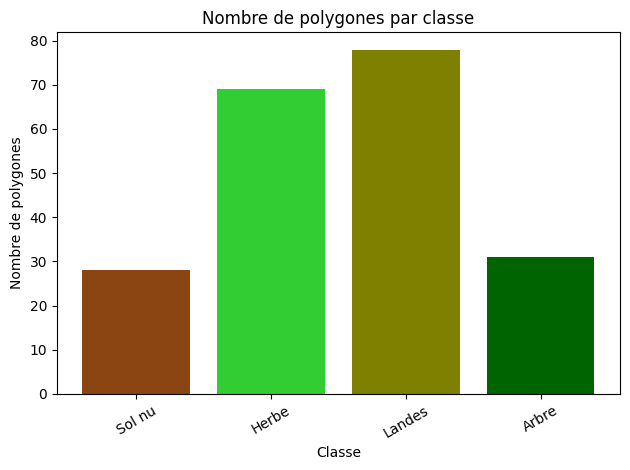

<Figure size 640x480 with 0 Axes>

In [3]:
# Nom du champ de classe 
field_name = "strate"

# Nomenclature des classes et couleurs
class_names = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

class_colors = {
    1: "saddlebrown",
    2: "limegreen",
    3: "olive",
    4: "darkgreen"
}

# Comptage des polygones par classe
counts_poly = gdf_strates[field_name].value_counts().sort_index()

# Remplacer les codes par les noms et couleurs
labels = [class_names[c] for c in counts_poly.index]
colors = [class_colors[c] for c in counts_poly.index]

# affficher nombre de polygone par classe
print(counts_poly)

# diagramme en bar des nombres de polygones par classe
plt.figure()
plt.bar(labels, counts_poly.values, color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig("/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_poly_by_class.png", dpi=300)

#### Commentaires
Les résultats montrent une dominance de la classe Landes (classe 3), qui possède le plus grand nombre de polygones. La classe Herbe (classe 2) arrive en seconde position, suivie par la classe Arbre (classe 4). En revanche, la classe Sol nu (classe 1) est faiblement représentée, ce qui indique une présence limitée de surfaces nues dans les échantillons analysés.

## Nombre de pixel par classe.

### Rasterization des échantillons




In [4]:
# Rasterization des echantillon polygonale 
out_sample_raster =  '/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif'
#ref_image = gdal.Open(image)
#cla.rasterization(fichier_strates, image, out_sample_raster, field_name)
fichier_ref = "/home/onyxia/work/data/projet_eval/pyrenees_24-25_B03.tif"

field_name = "strate"

mf.rasterize_shapefile(fichier_strates, fichier_ref, out_sample_raster, field_name)

Raster créé : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
# Chargement du fichier raster d'échantillons

sample_image_raster = rw.load_img_as_array('/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif').squeeze()


print("Shape raster strates :", sample_image_raster.shape)
print("Classes présentes :", np.unique(sample_image_raster))


Shape raster strates : (1655, 2103)
Classes présentes : [0 1 2 3 4]


In [6]:
# Comptage des classes d'échantillon

# Exclusion du nodata (0)
valeurs, comptage = np.unique(
    sample_image_raster[sample_image_raster != 0],
    return_counts=True
)

print("\nNombre de pixels par classe :")
for classe, nb_pixels in zip(valeurs, comptage):
    nom = class_names.get(int(classe), "Classe inconnue")
    print(f"{nom} (classe {int(classe)}) : {nb_pixels} pixels")


Nombre de pixels par classe :
Sol nu (classe 1) : 28 pixels
Herbe (classe 2) : 75 pixels
Landes (classe 3) : 80 pixels
Arbre (classe 4) : 26 pixels


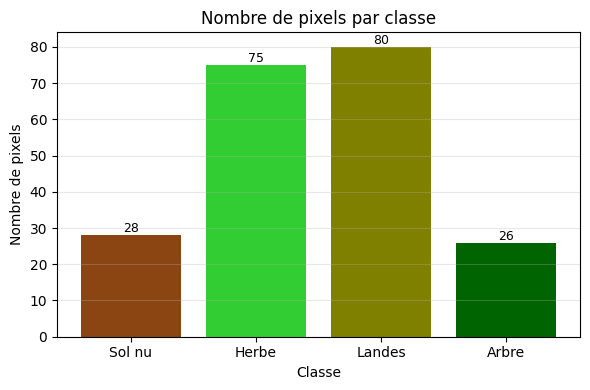

<Figure size 640x480 with 0 Axes>

In [7]:

# Labels et couleurs à partir des dictionnaires
labels = [class_names[int(v)] for v in valeurs]
colors = [class_colors[int(v)] for v in valeurs]

plt.figure(figsize=(6, 4))
plt.bar(labels, comptage, color=colors)

plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.grid(axis="y", alpha=0.3)

# Ajout des valeurs au-dessus des barres
for i, v in enumerate(comptage):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig("/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_pix_by_class.png", dpi=300)

#### commentaire

On observe que c'est la classe landes, suivi de la classe herbe qui occupent les plus grand nombre de pixels. Contrairement au graphique précédent, la classe sol nu occupe plus de pixels que la classe arbre.

# Méthodologie

# Phénologie des strates, mise en évidence des landes

In [8]:
# insertion des images de bande 3 et 5

pyr_b03 = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B03.tif'
pyr_b05 = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B05.tif'

output_path = '/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/ARI_serie_temp.tif'

# Calcul de l'indice Normalized Anthocyanin Reflectance Index (NARI)

mf.calculate_ari(pyr_b03 , pyr_b05, output_path)

Fichier ARI_serie_temp.tif de l'indice ARI a été créé avec succès !


In [9]:
# Vérification des caracteristiques de l'image ARI créé
ari_file_path = '/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/ARI_serie_temp.tif'

# Vérification des informations de l'image
mf.print_raster_info(ari_file_path)
#rw.get_image_dimension(ari_file)

---- Informations du raster ----
Résolution spatiale X : 10.0 m
Résolution spatiale Y : 10.0 m
Type d’encodage : Float32
Valeur NoData : -9999.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


### Fusion des images mono bandes en une seule image multi bande

In [10]:
# Fusion des images mono bande en en une image multibandes
directory = "/home/onyxia/work/data/projet_eval/"
extension = ".tif"

files = [
    os.path.join(directory, f)  
    for f in os.listdir(directory)
    if f.startswith("pyrenees_24-25") and f.endswith(extension)
]

print("Nombres d'images fusionées :", len(files))

# lecture des images en mémoire
images = []
for path in files:
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    images.append(arr)
    ds = None  # fermeture GDAL
#fusion des images

output_multibande = '/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif'
mf.merge_and_save_multiband(
    images= images,
    output_path=output_multibande,
    reference_raster_path=pyr_b03,
    nodata=-9999
)


Nombres d'images fusionées : 10


### Graphique de l'évolution del'indice ARI par strates et par dates

In [11]:
"""
ari_file = rw.load_img_as_array(ari_file_path)
sample_image_raster = rw.load_img_as_array('/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif').squeeze()
multi_band_image = rw.load_img_as_array('/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif').squeeze()

# définition des dates

class_labels=[1,2,3,4]

# Calcul des statistiques ARI par classe
moy, std = mf.extract_stats_by_class(
    image=ari_file,
    mask=sample_image_raster,
    classes=class_labels,
    nodata=-9999
)

nb_classe, multi_band_image= moy.shape


date = [
    "2024-10-11",
    "2024-10-21",
    "2024-11-28",
    "2024-12-05",
    "2025-01-14",
    "2025-02-23",
    "2025-05-29",
    "2025-06-18",
    "2025-07-16",
    "2025-08-24"
]



print(nb_classe)
print(multi_band_image)


assert len(date) == image_multi_band 

plt.figure(figsize=(12, 7))

colors = ["forestgreen", "darkorange", "saddlebrown"]
class_names = [
     "Sol nu",
     "Herbe",
     "Landes",
     "Arbre"
]
for i in range(nb_classe):
    plt.plot(
        date,
        moy[i, :],
        label=class_names[i],
        color=colors[i],
        marker="o",
        linewidth=2
    )

    plt.fill_between(
        date,
        moy[i, :] - std[i, :],
        moy[i, :] + std[i, :],
        color=colors[i],
        alpha=0.2
    )

plt.xlabel("Date")
plt.ylabel("Indice ARI moyen")
plt.title("Évolution temporelle de l’ARI par strate (Bretagne 2024–2025)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()"""

'\nari_file = rw.load_img_as_array(ari_file_path)\nsample_image_raster = rw.load_img_as_array(\'/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif\').squeeze()\nmulti_band_image = rw.load_img_as_array(\'/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif\').squeeze()\n\n# définition des dates\n\nclass_labels=[1,2,3,4]\n\n# Calcul des statistiques ARI par classe\nmoy, std = mf.extract_stats_by_class(\n    image=ari_file,\n    mask=sample_image_raster,\n    classes=class_labels,\n    nodata=-9999\n)\n\nnb_classe, multi_band_image= moy.shape\n\n\ndate = [\n    "2024-10-11",\n    "2024-10-21",\n    "2024-11-28",\n    "2024-12-05",\n    "2025-01-14",\n    "2025-02-23",\n    "2025-05-29",\n    "2025-06-18",\n    "2025-07-16",\n    "2025-08-24"\n]\n\n\n\nprint(nb_classe)\nprint(multi_band_image)\n\n\nassert len(date) == image_multi_band \n\nplt.figure(figsize=(12, 7))\n\ncolors = ["forestgreen", "darkorange", "saddlebrown"]\ncl

# 

# Production d’une carte de strates à l’échelle du pixel

In [12]:
# 1 --- definition des paramètres d'entrées et de sorties
# inputs
mon_dossier = '/home/onyxia/work/'

# Chargement des données utiles
sample_image_raster = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif')
multi_band_image = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif')


# Sample parameters
#test_size = 0.7
nb_iter = 5
nb_folds = 5
is_point = False # if is_point is True

field_name= "strate"

# outputs
suffix = '_CV{}fold_stratifed_x{}times'.format(nb_folds, nb_iter)
dossier_sortie = os.path.join(mon_dossier, 'results')
sortie_classif = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/carte_strates.tif')
sortie_matrix = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/ma_matrice{}.png'.format(suffix))
sortie_qualite = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/mes_qualites{}.png'.format(suffix))

In [13]:
# 2 --- Extraction des échantillons

if not is_point :
    X, Y, t = cla.get_samples_from_roi(multi_band_image, sample_image_raster)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(fichier_strates, image)
    image = rw.load_img_as_array(image)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(fichier_strates)
    Y = gdf.loc[:, nom_champs].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

In [14]:
print(X.shape)
print(Y.shape)

(209, 10)
(209, 1)


In [ ]:
# Iter on stratified K fold

kf = RepeatedStratifiedKFold(n_splits=nb_folds, n_repeats=nb_iter)

for train, test in kf.split(X, Y):
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]

    # 3 --- Train
    #clf = SVC(cache_size=6000)
   # Définition du modèle et de la grille d'hyperparamètres
    rf= RF(random_state=0)

    param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],    # nombre d'arbres
    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)
    "max_features": [None, "sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }

    # Grille de recherche
    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1  # utilise tous les CPU pour aller plus vite
    )

    # Entraînement avec recherche des meilleurs hyperparamètres 
    grid.fit(X_train, Y_train)
    
    print("Meilleurs hyperparamètres trouvés :")
    print(grid.best_params_)

    # Score moyen CV
    print(f"Score CV moyen : {grid.best_score_:.2f}")

    # Modèle final (entraîné sur tout le train) 
    best_model = grid.best_estimator_

    # 4 --- Test
    Y_predict = best_model.predict(X_test)
        
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict, labels=np.unique(Y_predict), output_dict=True)

    # store them
    list_report.append(mf.report_from_dict_to_df(report))


# Contribution des variables

Cette partie concerne la contribution des variables

,Variable,Importance
0,pyrenees_24-25_B02,0.073078
1,pyrenees_24-25_B03,0.053440
2,pyrenees_24-25_B04,0.286333
3,pyrenees_24-25_B05,0.097424
4,pyrenees_24-25_B06,0.078492
5,pyrenees_24-25_B07,0.136154
6,pyrenees_24-25_B08,0.043655
7,pyrenees_24-25_B8A,0.040859
8,pyrenees_24-25_B11,0.089609
9,pyrenees_24-25_B12,0.100956


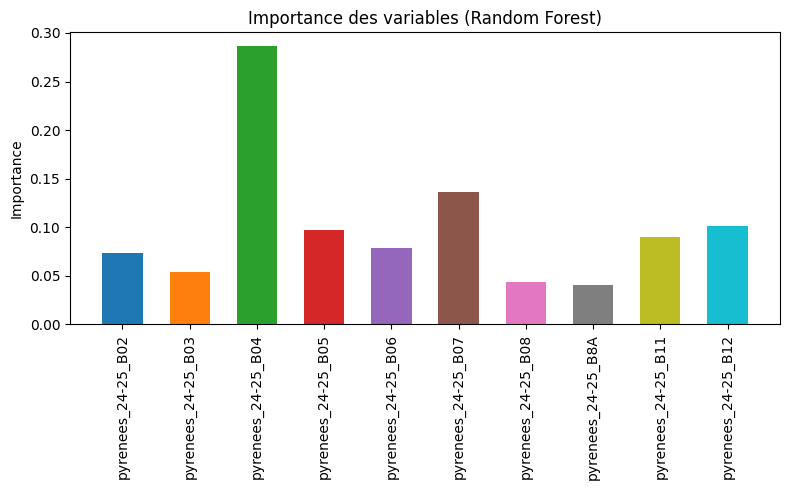

In [ ]:
# Importance des variables
importances = best_model.feature_importances_
feature_names = ["pyrenees_24-25_B02", 
                 "pyrenees_24-25_B03",
                 "pyrenees_24-25_B04",
                 "pyrenees_24-25_B05",
                 "pyrenees_24-25_B06",
                 "pyrenees_24-25_B07",
                 "pyrenees_24-25_B08",
                 "pyrenees_24-25_B8A",
                 "pyrenees_24-25_B11",
                 "pyrenees_24-25_B12"]

# DataFrame pour affichage tabulaire
df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
})
display(df_imp)


#Barplot avec couleur différente pour chaque variable
plt.figure(figsize=(8, 5))
colors = plt.cm.tab10.colors  # Palette avec 10 couleurs différentes
plt.bar(feature_names, importances, color=colors, width=0.6)

# Rotation des labels pour qu'ils soient lisibles
plt.xticks(rotation=90)
plt.title("Importance des variables (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()  # Ajuste l'affichage pour éviter que les labels soient coupés
plt.show()

### Matrice de Confusion

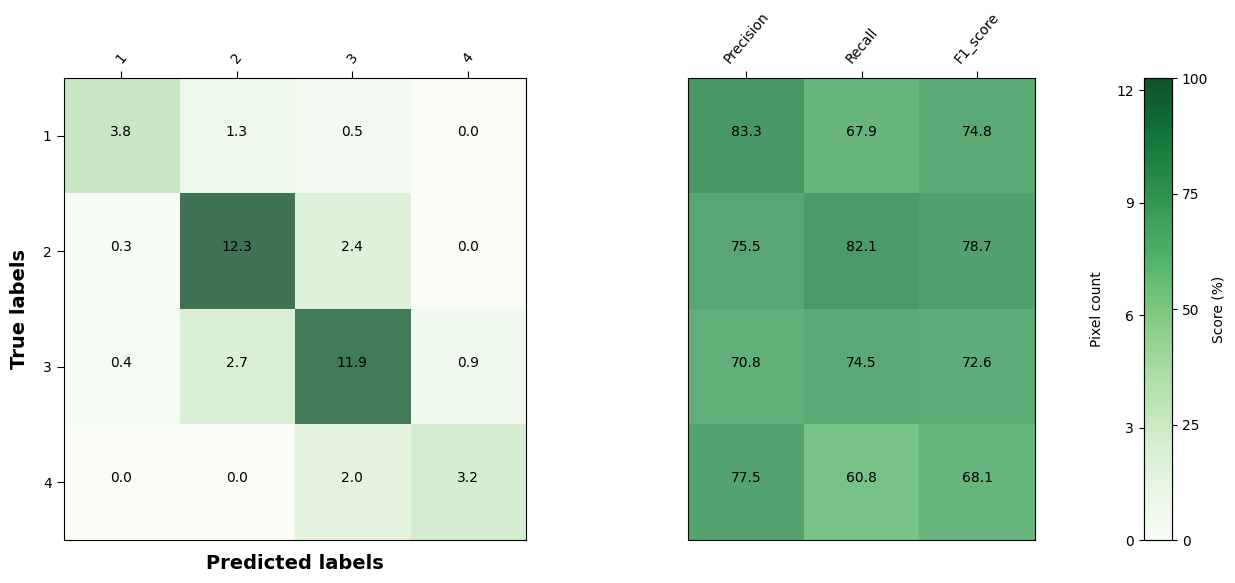

In [ ]:
# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

plots.plot_cm(mean_cm, np.unique(Y_predict))

### Calcul de l'accord globale moyen

In [ ]:
# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

### Moyenne et écart-type des rapports de Classification

In [ ]:

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)

### Affichage des des résultats dans un tableau

In [ ]:

a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
mean_df_report

,1,2,3,4
precision,0.851333,0.760112,0.714019,0.791905
recall,0.684000,0.821333,0.745000,0.610667
f1-score,0.741902,0.786782,0.725871,0.670719


In [ ]:
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)
std_df_report

,1,2,3,4
precision,0.158108,0.079053,0.079570,0.175232
recall,0.194164,0.087879,0.082765,0.199270
f1-score,0.155158,0.067539,0.063747,0.159496


### Affichage graphique des résultats

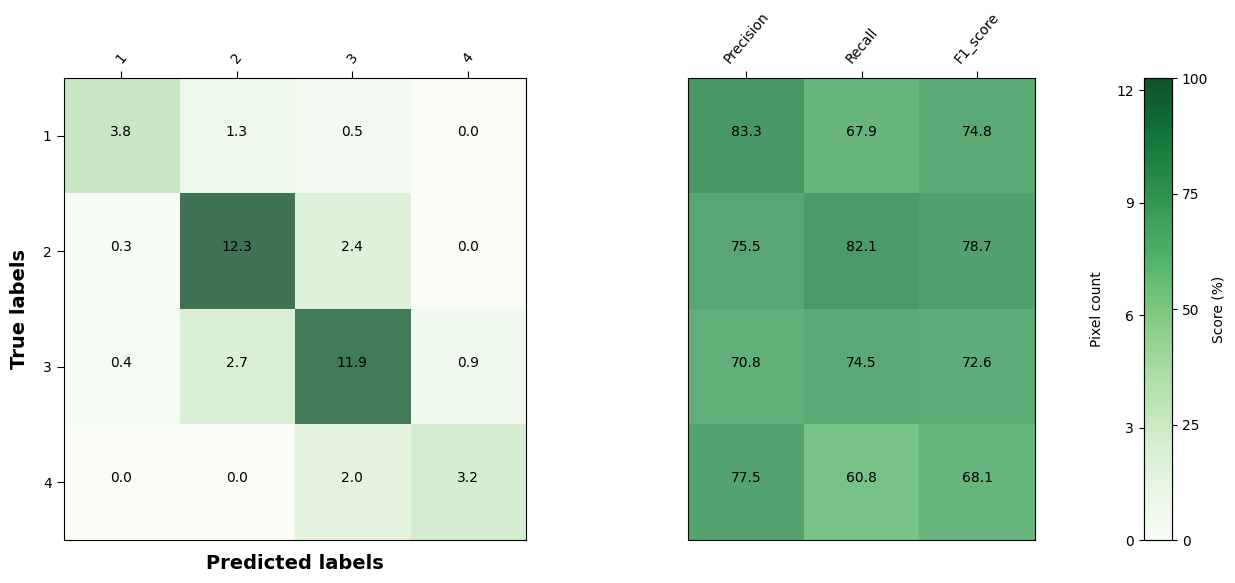

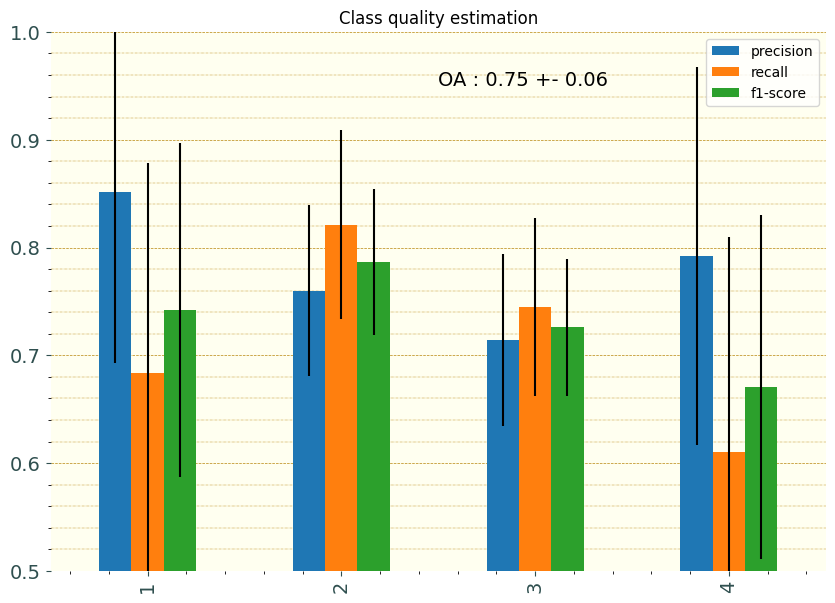

In [ ]:
# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(sortie_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(sortie_qualite, bbox_inches='tight')

In [ ]:
# Classification sur toute l'image multispectrale

multi_band_image_classification = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif')

image_to_be_classified = rw.load_img_as_array(multi_band_image_classification)

rows, cols, bands = image_to_be_classified.shape

X_image_to_be_classified = image_to_be_classified.reshape(rows * cols, bands)

#classification pixels par pixels

y_image_to_be_classified_pred = best_model.predict(X_image_to_be_classified)



In [ ]:
# Reconstruction et enregistrement de l'image l'image classifiée avec

classified_image = y_image_to_be_classified_pred.reshape(rows, cols)

ds = rw.open_image(multi_band_image_classification)

mf.write_classified_image_nodata0(
    sortie_classif,
    classified_image,
    ds_ref=ds,
    gdal_dtype=gdal.GDT_Int8
)

✅ Image enregistrée avec int8 et NoData = 0 : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/carte_strates.tif


In [ ]:
ds = rw.open_image('/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/carte_strates.tif')
band = ds.GetRasterBand(1)
nodata_val = band.GetNoDataValue()

print("Valeur NoData :", nodata_val)

Valeur NoData : 0.0


# Discussion des résultats